# CubeARnival: Chessboard
The aim of this project is to project a 3D cube on a 2D image containing a chessboard.<br>
This project is divided into sections : 
- Libraries : Importing the libraries used in the project
- Finding the Chessboard : To locate the chessboard in the 2D image
- Camera Calibration : To get important camera & image parameters
- Projecting Shapes : To project the required 3D shape on the image

## Libraries
First, import libraries and packages that will be used in the project
- OpenCV : Used for Computer Vision (CV) Applications
- Numpy : Used for numerical calculations
- Matplotlib : Used for plots and displaying images

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Finding the Chessboard

Define the functions used to find the chessboard.
1. First, estimate the number of rows and columns of the chessboard in the image
2. Then, the coordinates of the squares in the chessboard

In [2]:
def estimate_rows_and_cols(image, min_rows=3, max_rows=15, min_cols=3, max_cols=15):
    """This function is used to estimate the number of rows and columns there are in an image
    Input : Image - the image containing the chessboard
            min_rows - minimum number of rows
            max_rows - maximum number of rows
            min_cols - minimum number of columns
            max_cols - maximum number of columns
    Output : Number of (detected) rows and columns found in the image"""
    rows = None
    cols = None
    #Try all combinations of rows and columns to find the largest chessboard dimensions in the image
    for col in range(min_cols, max_cols):
        for row in range(min_rows, max_rows):
            ret, corners = cv2.findChessboardCorners(image, (row,col), None)
            if(ret):
                rows = row
                cols = col
    #return the chessboard dimensions
    return rows, cols

In [3]:
def get_corners(image, rows, cols):
    """This function returns the corners of the chessboard if it was found in the image and prints a message
    telling if the chessboard was found or not.
    Input: image - The image we're looking for the chessboard in
            rows - The number of rows in the chessboard
            cols - The number of cols in the chessboard
    Output: corners - locations of the corners of the chessboard
    """
    #find the corners of the chessboard's squares 
    ret, corners = cv2.findChessboardCorners(image, (rows, cols), None)
    #print a message telling if the chessboard was found or not
    if(ret):
        print("Chessboard Found")
    else:
        print("Chessboard Not Found")
    #return corners coordinates
    return ret, corners

Read the image and display it.

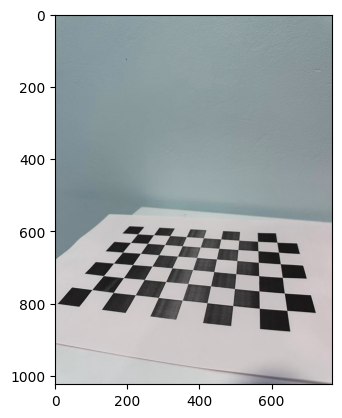

In [4]:
image = cv2.imread("chessboard.jpeg")
plt.imshow(image)
plt.show()

Locate the chessboard and find the coordinates of the squares' corners

In [5]:
#The line below is commented as it is time consuming, it can be uncommented for future uses.
# rows, cols = estimate_rows_and_cols(image)
rows, cols = 6, 9
ret, corners = get_corners(image, rows, cols)

Chessboard Found


Display the chessboard including the corners

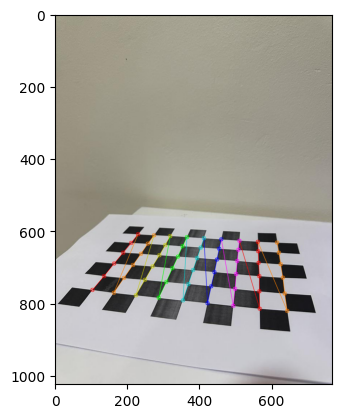

In [6]:
new_image = image.copy()
new_image = cv2.drawChessboardCorners(new_image, (rows, cols), corners, ret)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.show()

## Camera Calibration
In this section we want to get the camera's calibration parameters
1. Find the chessboard chessboard coordinates in the new coordinates system.
- This is done to allow us use the chessboard's squares as a new coordinates system.
2. Get the camera calibration parameters
3. Extra : Get the Homography matrix

In [7]:
def get_object_points(rows, cols, unit=1):
    """This function returns an array containing the coordinates of the chessboard corners in the object plane. The unit
    of measurement can be determined by changing the unit value, and the default value is 1 square.
    Input: rows - Number of rows 
            cols - Number of cols
            unit - Unit of measurement. Default is 1 square
    Output: array containing coordinated of each corner in the chessboard plane."""
    object_points = np.zeros((rows*cols, 3), np.float32)
    object_points[:,:2] = np.mgrid[:rows,:cols].T.reshape(-1,2) * unit
    return object_points

In [8]:
def calibrate_camera(object_points, image_points, image):
    """This function calibrates the camera and return important parameters
    Input : object_points - The points of the squares corners on the chessboard in the new coordinates system
            image_points - The points of the squares corners on the chessboard in the image
            image - The image containing the chessboard
    Output : 
            ret - Boolean value telling if the calibration was successful or not
            camera_matrix - matrix containing important camera parameters, like focal length etc.
            dist - tuple containing radial and tangential distortion parameters
            rot_vec - rotational distortion vector
            trans_vec - translational distortion vector"""
    ret, camera_matrix, dist, rot_vec, trans_vec = cv2.calibrateCamera([object_points], [image_points], image.shape[0:2][::-1], None, None)
    return ret, camera_matrix, dist, rot_vec, trans_vec

In [9]:
#Note: this function was not used in this code, but it is useful for future applications
def get_homography_matrix(object_points, image_points):
    """This function calculates the homography matrix by taking object and image points corresponding to the
    same plane and returns the matrix
    Input : object_points - The points of the squares corners on the chessboard in the new coordinates system
            image_points - The points of the squares corners on the chessboard in the image
    Output : h - The homography matrix
            status - Boolean value telling if the matrix was found or not """
    h, status = cv2.findHomography(object_points,image_points)
    return h, status

First, we need to calculate corners coordinates in the new coordinates system we want to follow (based on the squares of the chessboard) and the corners coordinates in the image.

In [10]:
object_points = get_object_points(rows, cols)
image_points = corners

Use the function defined above to get the camera calibration parameters

In [11]:
ret, camera_matrix, coeff, rot_vec, trans_vec = calibrate_camera(object_points, image_points, new_image)

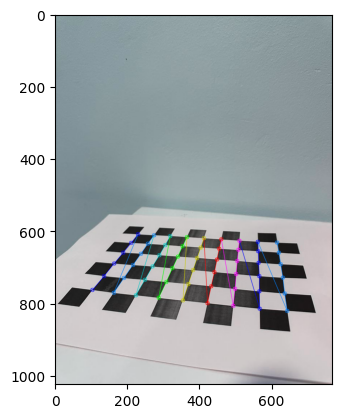

In [12]:
plt.imshow(new_image)
plt.show()

In [13]:
# calculate the homography matrix
# # h, status = get_homography_matrix(object_points, image_points)
# # h

## Projecting Shapes

In [14]:
def plane_to_image_point(points, rvec, tvec, mtx, dist):
    """This function takes the point in the object plane and gives the projected coordinates on the image plane
    Input : points - the points on the object plane
            rvec - rotational distortion vector
            tvec - translational distortion vector
            mtx - matrix containing important camera parameters, like focal length etc.
            dist - tuple containing radial and tangential distortion parameters
    Output : image_points - A numpy array containing coordinates of projected points on the image plane
    """
    #Use the projectPoints function in OpenCV to project the points from 3D to 2D plane.
    image_points, jac = cv2.projectPoints(
        np.array(points, float),
        np.array(rvec), 
        np.array(tvec), 
        np.array(mtx), 
        np.array(dist)
    )
    image_points = np.array(image_points, int)[0]
    return image_points

In [15]:
def get_cube_dimensions(center, edge_length):
    """This function returns the coordinates of a cube 
    Input : center - used to define the starting point of the cube
            edge_length - used to specify side length of the cube
    Output : cube - cube's coordinates"""
    #Define initial dimensions of a cube starting at [0,0,0] with edge lengt of 1
    dimensions = np.array([
        [0,0,0],
        [1,0,0],
        [1,1,0],
        [0,1,0],
        [0,0,-1],
        [1,0,-1],
        [1,1,-1],
        [0,1,-1]
    ])
    #scale the edge length  of the cube and shift the starting point 
    cube = dimensions * edge_length + center
    #return the coordinates of the cube
    return cube

In [16]:
def get_projected_dimensions(dimensions, rvec, tvec, mtx, dist):
    """This function takes the point in the object plane and gives the projected coordinates on the image plane
    Input : dimensions - the coordinates of the object we want to project on the image
            rvec - rotational distortion vector
            tvec - translational distortion vector
            mtx - matrix containing important camera parameters, like focal length etc.
            dist - tuple containing radial and tangential distortion parameters
    Output : projected_dimensions - A numpy array containing coordinates of projected object on the image plane
    """
    #create an empty array
    projected_dimensions = []
    #get all projected coordinates on the image plane
    for dimension in dimensions:
        projected_dimensions.append([
            plane_to_image_point(dimension,
                                rvec,
                                tvec,
                                mtx,
                                dist)[0]
        ])
    projected_dimensions = np.array(projected_dimensions)
    #return the projected dimensions
    return projected_dimensions

In [17]:
def project_cube(image, image_coordinates, colors = [(255,0,0), (0,255,0), (0,0,255)], thickness = 3):
    """This function takes an image an projects a cube on the image
    Input : image - the image we want to project a cube on
            image_coordinates - coordinates of the cube's vetrices
            colors - tuple containing colors used to draw the cube
            thickness - thickness of lines used to draw the cube
    Output : new_image - image containing the cube
    """
    new_image = image.copy()
    #Project the lower plane of the cube
    new_image = cv2.polylines(
        new_image, 
        pts=[image_coordinates[0:4]], 
        isClosed = True, 
        color = colors[0], 
        thickness = thickness
    )
    #project the sides connecting the lower plane with the upper one
    for i in range(0,4):
        new_image = cv2.line(
            new_image, 
            image_coordinates[0+i][0],
            image_coordinates[4+i][0], 
            color = colors[1], 
            thickness = thickness
        )
    #project the upper plane of the cube
    new_image = cv2.polylines(
        new_image, 
        pts=[image_coordinates[4:8]], 
        isClosed = True, 
        color = colors[2], 
        thickness = thickness
    )
    #return the new image
    return new_image

Compute the dimensions of the cube and project them on the image plane

In [18]:
cube_dimensions = get_cube_dimensions(0, 4)
cube_coordinates = get_projected_dimensions(cube_dimensions, rot_vec, trans_vec, camera_matrix, coeff)

Project the cube on the image then display the image containing the projetced cube

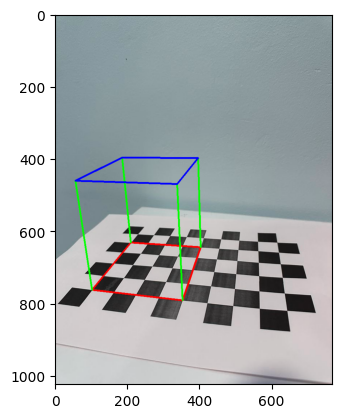

In [19]:
new_image = image.copy()
new_image = project_cube(new_image, cube_coordinates)
plt.imshow(new_image)
plt.show()